In [2]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MachineLearningIntegration").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.8 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [3]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639894 sha256=7e3cb35c83fd93dc08146081881b26099301055a43792dd2c36066139aabbb30
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [4]:
# dependecies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from pandas import to_datetime
from pandas.tseries.offsets import DateOffset as DateOffset
from datetime import datetime
import itertools
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# access local data
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# filepath
# path_1 = "Data/BicycleSales_2016-2021_cleaned.xlsx"
path_1 = '/content/gdrive/MyDrive/School/Georgia Tech/Data Science & Analytics Bootcamp/GT_DS_HW/Project-4_MachineLearningIntegration/Data/BicycleSales_2014-2021_redacted.xlsx'

# read data
sales_df = pd.read_excel(path_1)

sales_df

,SOrg.,DChl,Distribution Channel,Sold-to pt,Ship-to,Plnt,Matl Group,Material Group,Material,Month,Invoiced Quantity,Invoiced Quantity.1
0,10,11,E-Store,1025073,1025073,10,300,NaN,TB74255100,01/2014,2,EA
1,10,11,E-Store,1025073,1025073,10,300,NaN,TB72683000,01/2014,2,EA
2,10,11,E-Store,1025073,1025073,10,300,NaN,TB72683100,01/2014,2,EA
3,10,11,E-Store,1025073,1025073,10,300,NaN,TB35858000,01/2014,2,EA
4,10,11,E-Store,1025073,1025073,10,300,NaN,IB25400000,01/2014,2,EA
...,...,...,...,...,...,...,...,...,...,...,...,...
87018,10,20,Bicycle,1035929,1035929,30,300,NaN,SIB6988610,12/2021,1,EA
87019,10,20,Bicycle,1037697,1037697,30,300,NaN,TB74180100,12/2021,50,EA
87020,10,20,Bicycle,2000030,2000030,30,300,NaN,TB85975400,12/2021,5,EA
87021,10,20,Bicycle,2000030,2000030,30,300,NaN,TB00184900,12/2021,3,EA


In [7]:
# group and pivot invoiced quantity by date and material
# split Month into separate month and year components
sales_df[["Month", "Year"]] = sales_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
sales_df["Month"] = sales_df["Year"] + "-" + sales_df["Month"]

# group by date, sold-to, material
sales_gb_df = sales_df.groupby(
    ['Month', "Material"])[["Invoiced Quantity"]].sum()

sales_gb_df

Invoiced Quantity
Month   Material                     
2014-01 IB25400000                  4
        IB63464000                 56
        IB63829000                  3
        IB67445000                 20
        IB67447000                 64
...                               ...
2021-12 TB96908400                 17
        TB96909000                 94
        TB96909200                  7
        TB96909300                 12
        TB96910100                 45

[25263 rows x 1 columns]

In [8]:
# pivot sold to and material
sales_pivot_df = pd.pivot_table(sales_gb_df,
                           values = 'Invoiced Quantity',
                           index = 'Month',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

sales_pivot_df = sales_pivot_df.reset_index()
sales_pivot_df['Month'] = to_datetime(sales_pivot_df['Month'])
sales_pivot_df = sales_pivot_df.set_index(['Month'])

sales_pivot_df

Material,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,IB00137300,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
Month,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-04-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,0,0,0,0,0,0,30,0,0,126,...,20,0,0,0,0,0,42,0,0,0
2021-09-01,0,0,0,0,0,0,20,0,126,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-01,0,0,0,0,0,0,60,0,0,0,...,0,0,0,0,0,0,0,15,0,0


In [9]:
sales_1_df = sales_pivot_df[['TB96805000']]
sales_1_df.rename(columns={'TB96805000':'Sales'}, inplace = True)
sales_1_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Material,Sales
Month,
2014-01-01,0
2014-02-01,0
2014-03-01,125
2014-04-01,35
2014-05-01,28
...,...
2021-08-01,3127
2021-09-01,0
2021-10-01,0


In [10]:
# dataframe format for prophet
df = sales_1_df.reset_index()
df.columns = ['ds', 'y']
df['floor'] = -.001
df['cap'] = 30000
df

,ds,y,floor,cap
0,2014-01-01,0,-0.001,30000
1,2014-02-01,0,-0.001,30000
2,2014-03-01,125,-0.001,30000
3,2014-04-01,35,-0.001,30000
4,2014-05-01,28,-0.001,30000
...,...,...,...,...
91,2021-08-01,3127,-0.001,30000
92,2021-09-01,0,-0.001,30000
93,2021-10-01,0,-0.001,30000
94,2021-11-01,0,-0.001,30000


### Prohpet

In [11]:
# fit prophet model and predict
m = Prophet()

m.fit(df)
future = m.make_future_dataframe(periods=24, freq='M')

fcst = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
# renaming output dataframe
prophet_df = fcst[{'ds', 'yhat'}]
prophet_df.columns = ['Month', 'Prophet']
prophet_df = prophet_df.set_index(['Month'])
prophet_df['Prophet'] = prophet_df['Prophet'].round(decimals=0)
prophet_df['Prophet'] = prophet_df['Prophet'].apply(np.int64)
prophet_df

,Prophet
Month,
2014-01-01,-65
2014-02-01,-52
2014-03-01,-92
2014-04-01,27
2014-05-01,122
...,...
2023-07-31,402
2023-08-31,395
2023-09-30,702


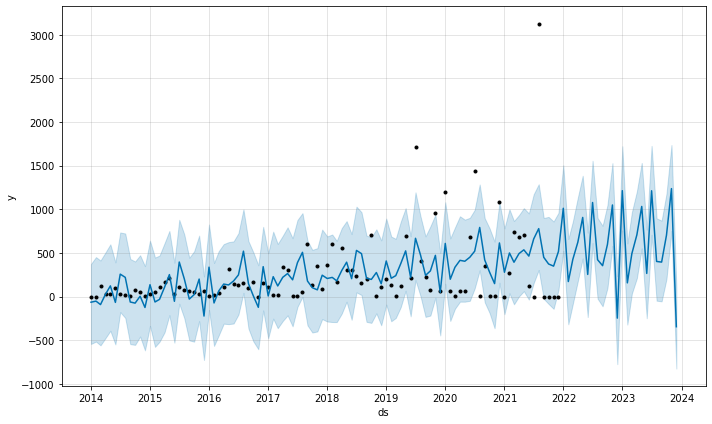

In [13]:
# plot
fig = m.plot(fcst)

In [17]:
# cross validation
cutoffs = pd.to_datetime(['2018-12-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', period='365 days', parallel="processes")

# performance
df_p = performance_metrics(df_cv, rolling_window=1)

df_p

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7efd41e9fd10>


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,250665.722155,500.66528,353.082593,4.390326,0.758539,0.917381,0.333333


In [18]:
# Hyperparameter tuning
param_grid = {  
    'changepoint_prior_scale': [0.001, .005, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['logistic']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    cutoffs = pd.to_datetime(['2018-12-01'])
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', period='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

tuning_results

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7efd41e563d0>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7efd41ea6590>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7efd416a0350>
INFO:prophet:Disabling weekly seasonality. Run prophet 

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,growth,rmse
0,0.001,0.01,additive,logistic,475.392553
1,0.001,0.01,multiplicative,logistic,473.725044
2,0.001,0.10,additive,logistic,489.151464
3,0.001,0.10,multiplicative,logistic,529.329408
4,0.001,1.00,additive,logistic,490.186791
5,0.001,1.00,multiplicative,logistic,617.189535
6,0.001,10.00,additive,logistic,492.463060
7,0.001,10.00,multiplicative,logistic,756.070989
8,0.005,0.01,additive,logistic,475.322269
9,0.005,0.01,multiplicative,logistic,473.835744


In [19]:
# Identify best hyperparameter
best_parameters = tuning_results.iloc[tuning_results['rmse'].idxmin(),:]
cps = best_parameters['changepoint_prior_scale']
sps = best_parameters['seasonality_prior_scale']
sm = best_parameters['seasonality_mode']
growth = best_parameters['growth']
best_parameters

changepoint_prior_scale             0.001
seasonality_prior_scale              0.01
seasonality_mode           multiplicative
growth                           logistic
rmse                           473.725044
Name: 1, dtype: object

In [20]:
# model with best hyperameters
m = Prophet(seasonality_mode=sm, changepoint_prior_scale=cps, seasonality_prior_scale=sps)

m.fit(df)
future = m.make_future_dataframe(periods=24, freq='M')

fcst_tuned = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
# renaming output dataframe
prophet_tuned_df = fcst_tuned[{'ds', 'yhat'}]
prophet_tuned_df.columns = ['Month', 'Prophet_tuned']
prophet_tuned_df = prophet_tuned_df.set_index(['Month'])
prophet_tuned_df['Prophet_tuned'] = prophet_tuned_df['Prophet_tuned'].round(decimals=0)
prophet_tuned_df['Prophet_tuned'] = prophet_tuned_df['Prophet_tuned'].apply(np.int64)

prophet_tuned_df

,Prophet_tuned
Month,
2014-01-01,-18
2014-02-01,-12
2014-03-01,-7
2014-04-01,-1
2014-05-01,4
...,...
2023-07-31,631
2023-08-31,631
2023-09-30,636


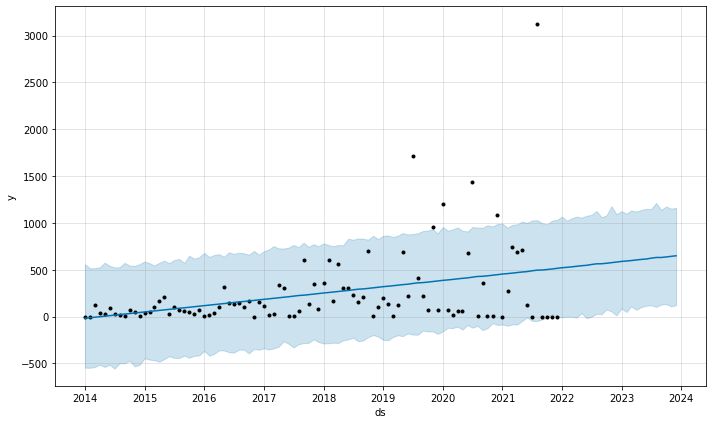

In [22]:
# plot
fig = m.plot(fcst_tuned)

In [23]:
# performance
cutoffs = pd.to_datetime(['2018-12-01'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', period='365 days', parallel="processes")

df_p = performance_metrics(df_cv, rolling_window=1)
df_p

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7efd41e80690>


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,234471.677232,484.222756,327.87234,3.812936,0.733382,0.877879,0.416667


### load to postgres RDS

In [ ]:
#Create PySpark DataFrame from Pandas
prophet_sparkDF=spark.createDataFrame(prophet_df.reset_index()) 
prophet_sparkDF.printSchema()
prophet_sparkDF.show()

In [ ]:
#Create PySpark DataFrame from Pandas
sales_1_sparkDF=spark.createDataFrame(sales_1_df.reset_index()) 
sales_1_sparkDF.printSchema()
sales_1_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Sales: long (nullable = true)

+-------------------+-----+
|              Month|Sales|
+-------------------+-----+
|2014-01-01 00:00:00|    0|
|2014-02-01 00:00:00|    0|
|2014-03-01 00:00:00|  125|
|2014-04-01 00:00:00|   35|
|2014-05-01 00:00:00|   28|
|2014-06-01 00:00:00|   97|
|2014-07-01 00:00:00|   27|
|2014-08-01 00:00:00|   13|
|2014-09-01 00:00:00|    8|
|2014-10-01 00:00:00|   74|
|2014-11-01 00:00:00|   50|
|2014-12-01 00:00:00|    4|
|2015-01-01 00:00:00|   34|
|2015-02-01 00:00:00|   49|
|2015-03-01 00:00:00|  106|
|2015-04-01 00:00:00|  171|
|2015-05-01 00:00:00|  214|
|2015-06-01 00:00:00|   25|
|2015-07-01 00:00:00|  106|
|2015-08-01 00:00:00|   73|
+-------------------+-----+
only showing top 20 rows



In [ ]:
#Create PySpark DataFrame from Pandas
prophet_tuned_sparkDF=spark.createDataFrame(prophet_tuned_df.reset_index()) 
prophet_tuned_sparkDF.printSchema()
prophet_tuned_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Prophet_tuned: long (nullable = true)

+-------------------+-------------+
|              Month|Prophet_tuned|
+-------------------+-------------+
|2014-01-01 00:00:00|          -18|
|2014-02-01 00:00:00|          -12|
|2014-03-01 00:00:00|           -7|
|2014-04-01 00:00:00|           -1|
|2014-05-01 00:00:00|            4|
|2014-06-01 00:00:00|           10|
|2014-07-01 00:00:00|           16|
|2014-08-01 00:00:00|           21|
|2014-09-01 00:00:00|           27|
|2014-10-01 00:00:00|           32|
|2014-11-01 00:00:00|           38|
|2014-12-01 00:00:00|           44|
|2015-01-01 00:00:00|           50|
|2015-02-01 00:00:00|           55|
|2015-03-01 00:00:00|           60|
|2015-04-01 00:00:00|           66|
|2015-05-01 00:00:00|           72|
|2015-06-01 00:00:00|           77|
|2015-07-01 00:00:00|           83|
|2015-08-01 00:00:00|           89|
+-------------------+-------------+
only showing top 20 rows



In [ ]:
# Configure settings for RDS
mode = "overwrite"
jdbc_url="jdbc:postgresql://database-1.cc8swew422eu.us-east-1.rds.amazonaws.com:5432/postgres"
config = {"user":"pgadmin", 
          "password": "postgres", 
          "driver":"org.postgresql.Driver"}

In [ ]:
# Write DataFrame to prophet table in RDS

prophet_sparkDF.write.jdbc(url=jdbc_url, table='prophet', mode=mode, properties=config)
sales_1_sparkDF.write.jdbc(url=jdbc_url, table='sales', mode=mode, properties=config)
prophet_tuned_sparkDF.write.jdbc(url=jdbc_url, table='prophet_tuned', mode=mode, properties=config)